In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
%matplotlib inline
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
import lightgbm as lgb
from catboost import CatBoostClassifier, Pool
from catboost.utils import eval_metric
from sklearn.metrics import roc_auc_score
import os
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind, zscore
from statsmodels.stats.weightstats import ztest
from scipy.stats import chi2_contingency

In [21]:
df = pd.read_csv('Dataset/complete_dataset')

In [22]:
print(df)

              id  CustomerId         Surname  CreditScore Geography  Gender  \
0            0.0  15674932.0  Okwudilichukwu        668.0    France    Male   
1            1.0  15749177.0   Okwudiliolisa        627.0    France    Male   
2            2.0  15694510.0           Hsueh        678.0    France    Male   
3            3.0  15741417.0             Kao        581.0    France    Male   
4            4.0  15766172.0       Chiemenam        716.0     Spain    Male   
...          ...         ...             ...          ...       ...     ...   
330064   87314.0  15776807.0         Brennan        654.0    France    Male   
330065   72707.0  15706071.0            Chiu        667.0   Germany    Male   
330066  238016.0  15651137.0           White        755.0     Spain    Male   
330067  226920.0  15694506.0           Clark        727.0     Spain    Male   
330068   71060.0  15783883.0        Li Fonti        535.0    France  Female   

         Age  Tenure    Balance  NumOfProducts  Has

In [23]:
print(df.isnull().sum().sum())

115528


In [24]:
print(df.duplicated().sum())

55011


In [25]:
df = df.drop_duplicates()

In [26]:
def fill_missing_values(df):
    
    for col in df.select_dtypes(include=['float64', 'int64']).columns:
        df[col].fillna(df[col].mean(), inplace=True)
    for col in df.select_dtypes(include=['object']).columns:
        df[col].fillna(df[col].mode()[0], inplace=True)
    
    return df
            
fill_missing_values(df)

/tmp/ipykernel_30/1655620123.py:4: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.



/tmp/ipykernel_30/1655620123.py:6: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,0.0,1.567493e+07,Okwudilichukwu,668.000000,France,Male,33.000000,3.000000,0.00000,2.000000,1.000000,0.000000,181449.970000,0.000000
1,1.0,1.574918e+07,Okwudiliolisa,627.000000,France,Male,33.000000,1.000000,0.00000,2.000000,1.000000,1.000000,49503.500000,0.000000
2,2.0,1.569451e+07,Hsueh,678.000000,France,Male,40.000000,10.000000,0.00000,2.000000,1.000000,0.000000,184866.690000,0.000000
3,3.0,1.574142e+07,Kao,581.000000,France,Male,34.000000,2.000000,148882.54000,1.000000,1.000000,1.000000,84560.880000,0.000000
4,4.0,1.576617e+07,Chiemenam,716.000000,Spain,Male,33.000000,5.000000,0.00000,2.000000,1.000000,1.000000,15068.830000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
275053,275053.0,1.577413e+07,Cox,575.000000,France,Female,36.000000,4.000000,178032.53000,1.000000,1.000000,1.000000,42181.680000,0.000000
275054,275054.0,1.572846e+07,Ch'iu,712.000000,France,Male,31.000000,2.000000,0.00000,2.000000,1.000000,0.000000,16287.380000,0.000000
275055,275055.0,1.568754e+07,Yegorova,709.000000,France,Female,32.000000,3.000000,0.00000,1.000000,1.000000,1.000000,158816.580000,0.000000
275056,275056.0,1.566394e+07,Tuan,621.000000,France,Female,37.000000,7.000000,87848.39000,1.000000,1.000000,0.000000,24210.560000,0.000000


In [27]:
print(df.isnull().sum().sum())

0


In [28]:
print(df.duplicated().sum())

0


In [29]:
num_col = df.select_dtypes(include=['number']).columns
print(num_col)

Index(['id', 'CustomerId', 'CreditScore', 'Age', 'Tenure', 'Balance',
       'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary',
       'Exited'],
      dtype='object')


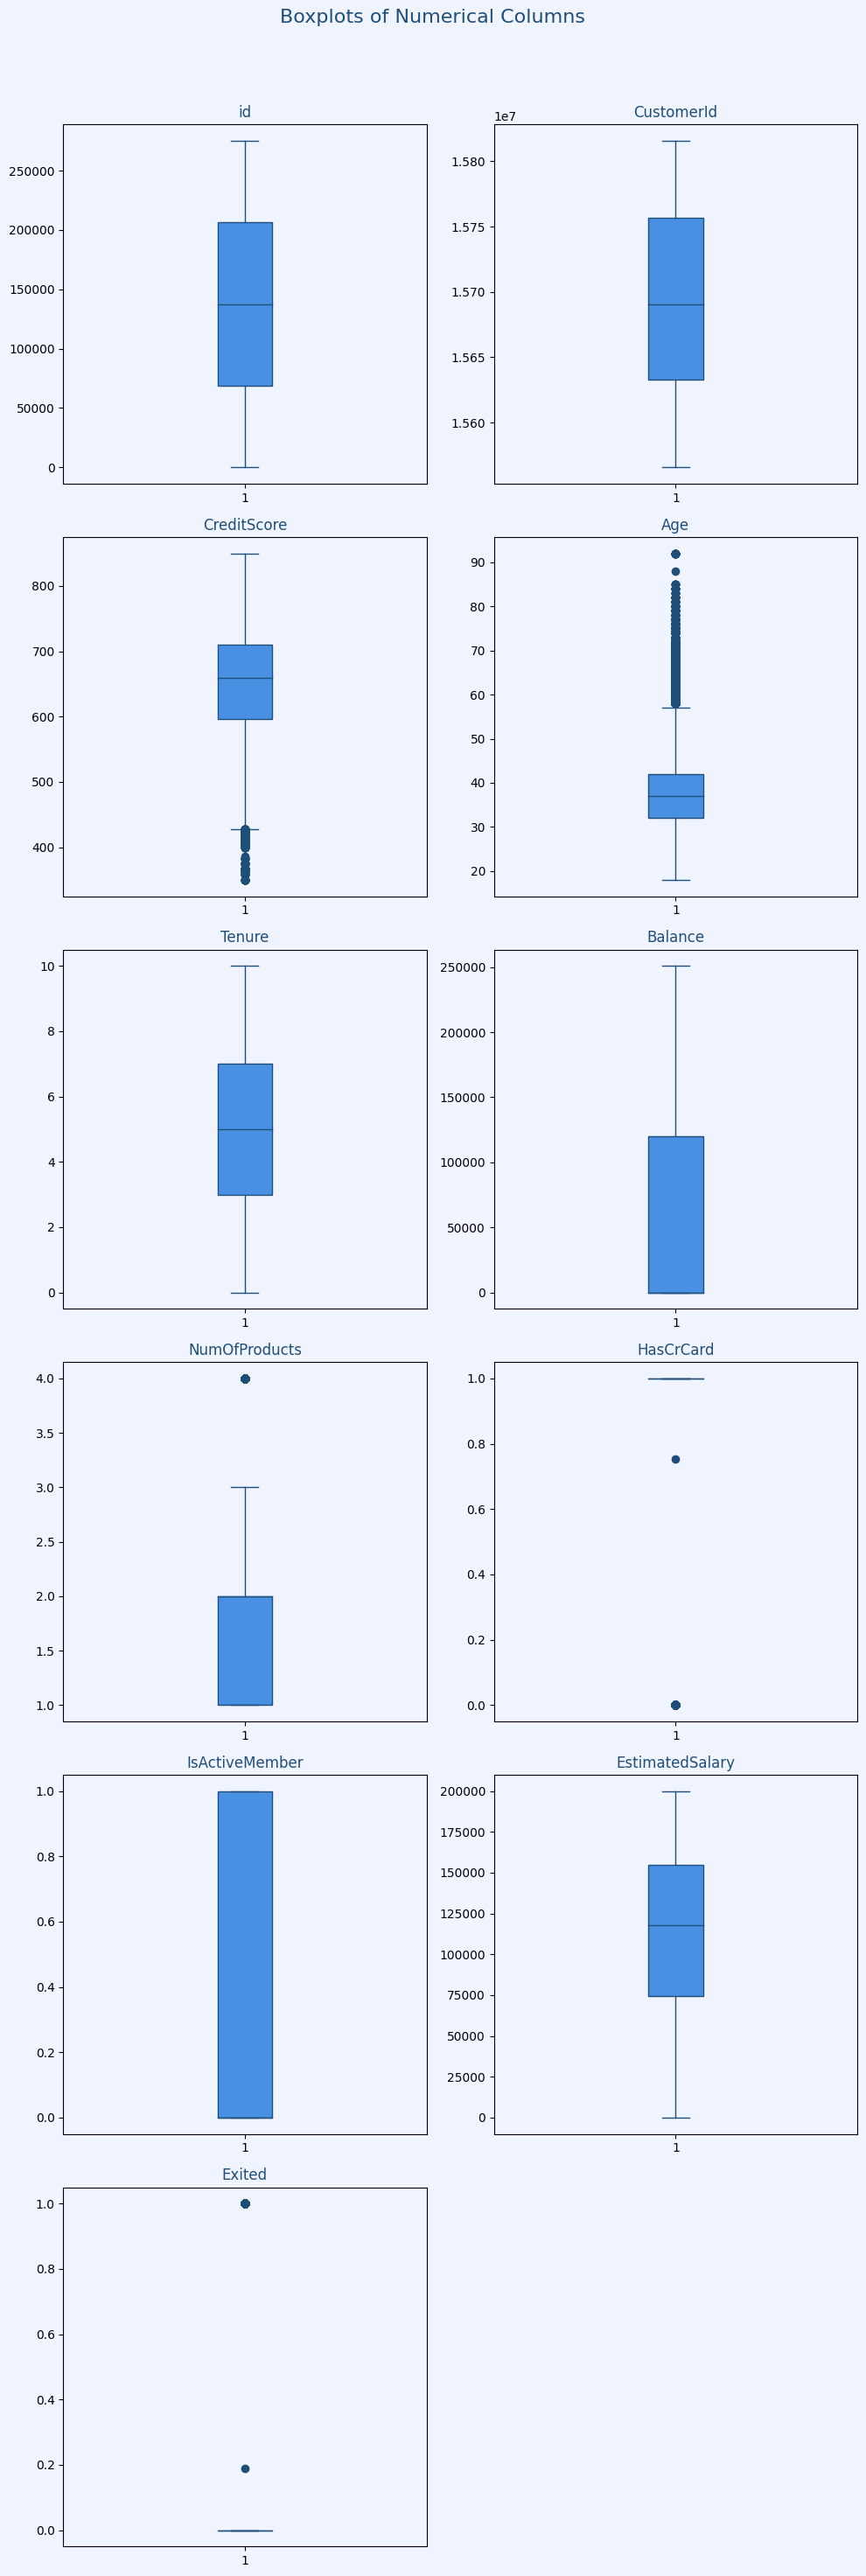

In [35]:
num_col = df.select_dtypes(include=['number']).columns
num_plots = len(num_col)
cols = 2
rows = (num_plots // cols) + (num_plots % cols > 0)

# Set up the figure and axes
fig, axes = plt.subplots(rows, cols, figsize=(10, 5 * rows))
fig.suptitle("Boxplots of Numerical Columns", fontsize=16, color="#1f4e79")
fig.patch.set_facecolor('#f0f4ff')  # Light blue background for the entire figure

# Plot each numerical column in a subplot
for i, col in enumerate(num_col):
    ax = axes[i // cols, i % cols] if rows > 1 else axes[i % cols]
    ax.boxplot(df[col].dropna(), patch_artist=True,
               boxprops=dict(facecolor='#4a90e2', color='#1f4e79'),
               whiskerprops=dict(color='#1f4e79'),
               capprops=dict(color='#1f4e79'),
               medianprops=dict(color='#1f4e79'),
               flierprops=dict(markerfacecolor='#1f4e79', markeredgecolor='#1f4e79'))
    ax.set_title(col, color="#1f4e79")
    ax.set_facecolor('#f0f4ff')  # Light blue background for individual plots

# Remove any unused subplots
if num_plots % cols != 0:
    for j in range(num_plots, rows * cols):
        fig.delaxes(axes.flatten()[j])

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

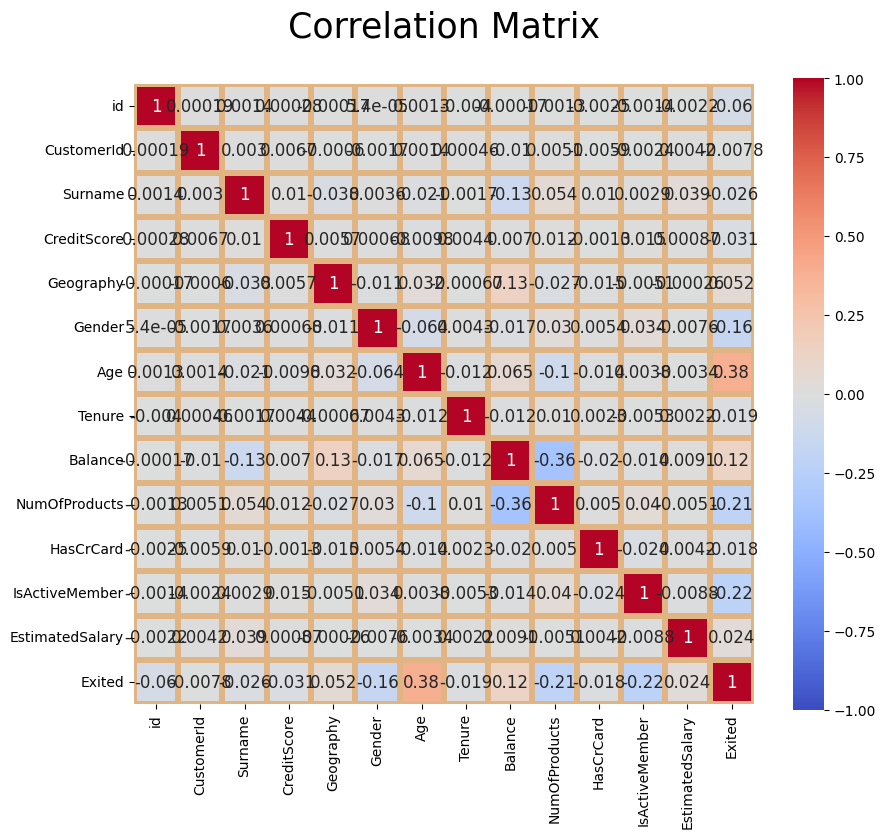

In [36]:

df_corr = df.copy()

catcol = [col for col in df_corr.columns if df_corr[col].dtype == "object"]
le = LabelEncoder()
for col in catcol:
    df_corr[col] = le.fit_transform(df_corr[col])

plt.subplots(figsize=(10, 10))

sns.heatmap(
    df_corr.corr(), 
    cmap="coolwarm", 
    square=True, 
    cbar_kws=dict(shrink=0.82),
    annot=True, 
    vmin=-1, 
    vmax=1, 
    linewidths=3, 
    linecolor='#e0b583', 
    annot_kws=dict(fontsize=12)
)
plt.title("Correlation Matrix\n", fontsize=25)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.show()

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.



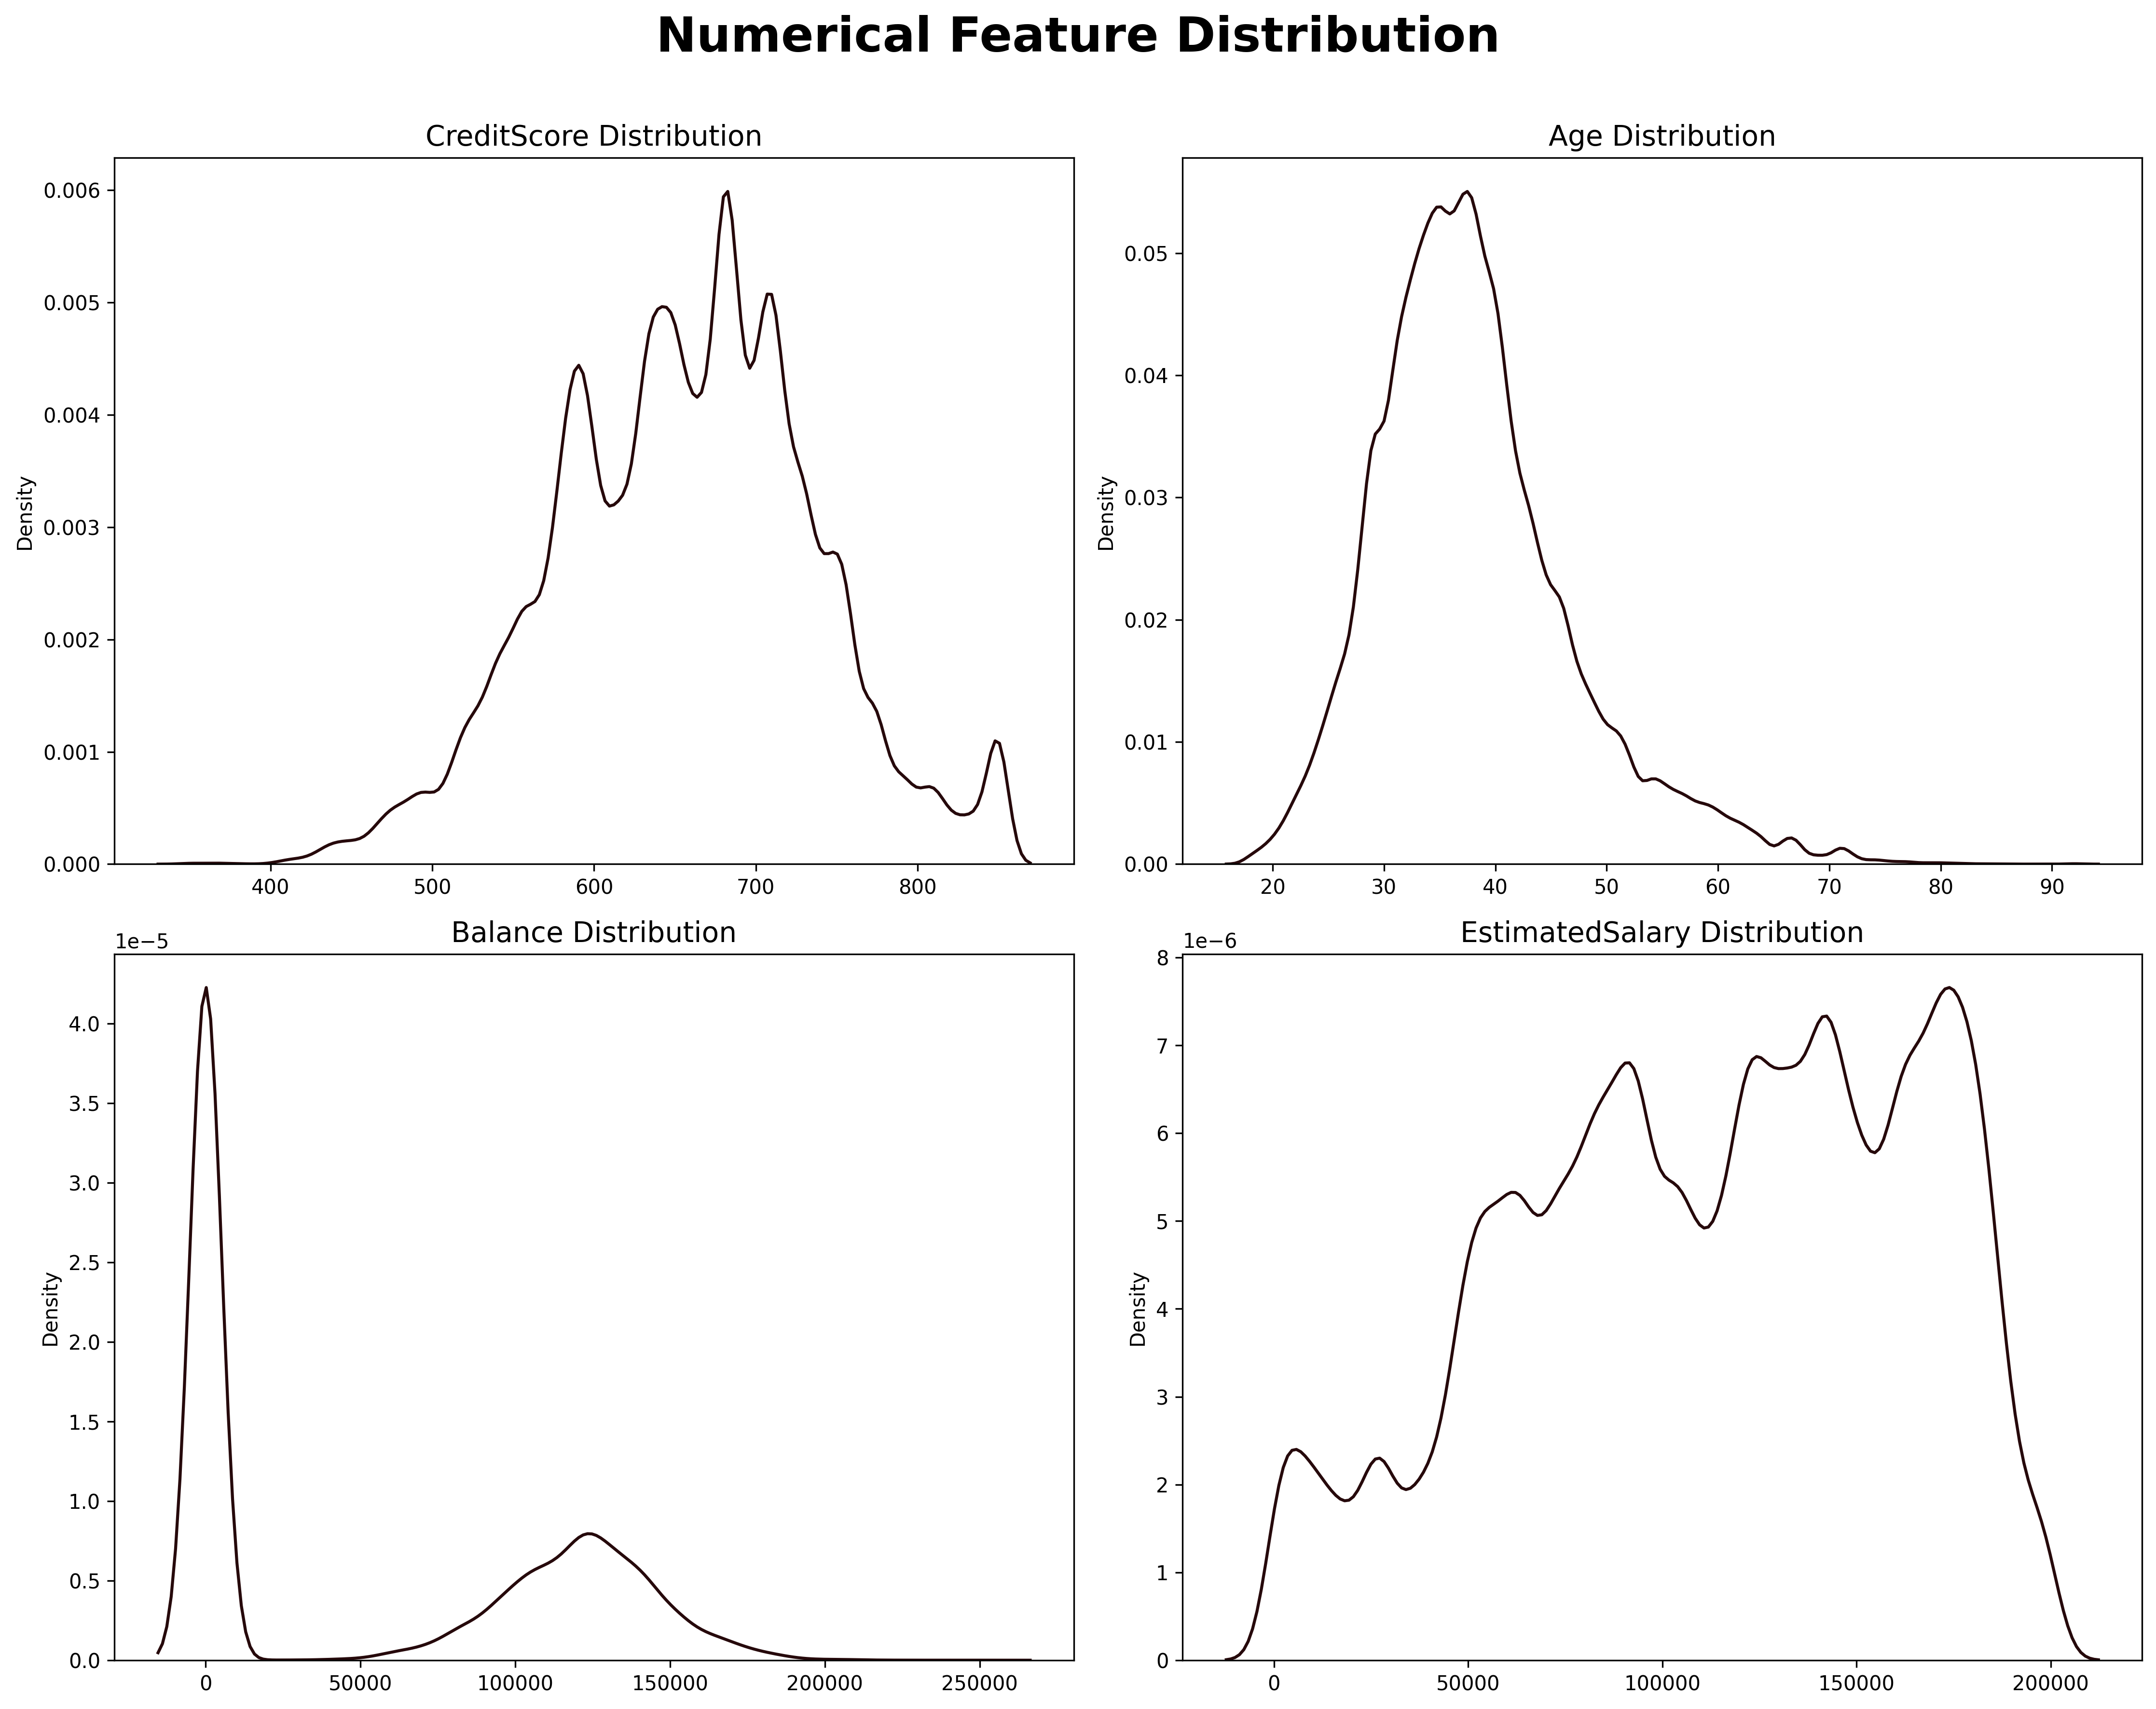

In [37]:
palette = sns.color_palette("coolwarm", n_colors=2)

fig, ax = plt.subplots(2, 2, figsize=(15, 12), dpi=300)
ax = ax.flatten()

numerical_variables = ['CreditScore', 'Age', 'Balance', 'EstimatedSalary']
for i, column in enumerate(numerical_variables):
    sns.kdeplot(df[column], ax=ax[i], color='#26090b')        
    ax[i].set_title(f'{column} Distribution', size=14)
    ax[i].set_xlabel(None)
    
fig.suptitle('Numerical Feature Distribution\n', fontsize=24, fontweight='bold')
plt.tight_layout()
plt.show()